<a href="https://colab.research.google.com/github/SiYangming/sora-tutorial/blob/main/docs/chapter2/chapter2_3/patch-BestPractice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 图像预处理：
具体步骤如下：

读取图像： 使用 tf.keras.utils.load_img 函数从给定路径 /mnt/workspace/image_1.png 读取图像。设置参数 grayscale=False 表示读取彩色图像，color_mode='rgb' 指定了图像为 RGB 格式。由于 target_size=None，图像将保持原始尺寸不变。interpolation='nearest' 表示在缩放时采用最近邻插值方法。

转换为数组格式： 使用 tf.keras.preprocessing.image.img_to_array 将读取到的 PIL 图像对象转换为 Numpy 数组（在 TensorFlow 中表示为 tensor）。

图像缩放： 判断条件 if (scale)，如果为真，则使用 tf.image.resize 对图像进行缩放到指定大小（即 image_dim）。这里采用了双线性插值方法 (ResizeMethod.BILINEAR) 进行缩放，并且不保留原始宽高比 (preserve_aspect_ratio=False)。

裁剪图像： 使用 tf.image.crop_to_bounding_box 对图像进行裁剪，裁剪区域是从原图的左上角 (0, 0) 开始，裁剪出一个 image_dim x image_dim 大小的正方形图像。

返回处理后的图像： 最终返回经过上述预处理步骤后得到的图像数组（tensor）。

这段代码，能够以统一大小加载并预处理图片，这对于后续将图片输入到深度学习模型中是非常常见的做法。



In [13]:
import tensorflow as tf

# Image preprocessing

def read_image(image_file="demo_highfive.jpg", scale=True, image_dim=336):

    image = tf.keras.utils.load_img(
        image_file, grayscale=False, color_mode='rgb', target_size=None,
        interpolation='nearest'
    )
    image_arr_orig = tf.keras.preprocessing.image.img_to_array(image)
    if(scale):
        image_arr_orig = tf.image.resize(
            image_arr_orig, [image_dim, image_dim],
            method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False
        )
    image_arr = tf.image.crop_to_bounding_box(
        image_arr_orig, 0, 0, image_dim, image_dim
    )

    return image_arr



## 创建Patch
这段代码是使用TensorFlow库来从输入图像中提取32x32大小的图像块（即patch）并将其转化为一维向量。以下是详细的步骤解释：

def create_patches(image): 定义了一个名为create_patches的函数，参数为image图像张量。

im = tf.expand_dims(image, axis=0)：使用TensorFlow的expand_dims函数在图像数据的第0维（batch维度）增加一个维度，以便能够处理一批图片，即使现在我们只有一张图片。

patches = tf.image.extract_patches(...)：调用TensorFlow的extract_patches函数从图像中提取 patches。这里的设置表明：

images=im 表示要提取 patches 的图像。
sizes=[1, 32, 32, 1] 表示每个 patch 的大小为 32x32 像素，并且深度（通道数）与原图相同。
strides=[1, 32, 32, 1] 表示在宽度和高度方向上以32像素为步长移动来提取相邻的 patch。
rates=[1, 1, 1, 1] 表示采样率，在此处等于 strides，意味着没有进行亚像素采样。
padding="VALID" 表示不进行额外的填充，只对完全包含在原始图像内的 patch 进行提取。
patch_dims = patches.shape[-1]：获取提取出的 patches 在最后一个维度（在这里指的是每个 patch 的元素数量，即32*32*C，C为通道数）的大小。

patches = tf.reshape(patches, [1, -1, patch_dims])：将提取到的一系列 patches 进行reshape，将其展平为一个一维数组，其中第一个维度表示 batch 大小（这里为1），第二个维度是所有 patches 的总数量（-1表示自动计算这一维度的大小），第三个维度是每个 patch 的元素数量。

函数最后返回经过处理得到的 patches 张量。

image_arr = read_image()：假设这是一个读取图像并转换为张量的函数，用于获取待处理的图像。

patches = create_patches(image_arr)：调用create_patches函数，传入读取到的图像数据，得到该图像分割后的 patches。

In [14]:
# Patching
def create_patches(image):
    im = tf.expand_dims(image, axis=0)
    patches = tf.image.extract_patches(
        images=im,
        sizes=[1, 32, 32, 1],
        strides=[1, 32, 32, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [1, -1, patch_dims])

    return patches

image_arr = read_image()
patches = create_patches(image_arr)

## 绘制patches
这段代码是使用`matplotlib`库在Python中绘制图像及其分块patches的函数定义，并在最后调用了这两个函数来显示结果。它假定您正在处理一个TensorFlow环境，其中`image_arr`是一个图像数组（可能已经被转换为浮点数），而`patches`是一个形状如`(batch_size, num_patches, patch_height, patch_width, channels)`的张量，其中包含了从`image_arr`图像中提取出的多个小图像块（patches）。

函数解释：
1. `render_image_and_patches(image, patches)`
   - 这个函数首先创建一个新的图形窗口，并设置其大小为16x16英寸。
   - 使用`suptitle`添加标题"Cropped Image"，并设置字体大小为48。
   - 使用`plt.imshow`显示原始`image_arr`图像，将其转换回uint8类型以便正确显示，并关闭坐标轴显示。
   - 计算patches矩阵的行数和列数（假设patch的数量是平方数）。
   - 创建第二个图形窗口同样大小为16x16英寸，添加标题"Image Patches"。
   - 遍历`patches`的第一个样本的所有patch，对每个patch进行以下操作：
     - 在网格布局中创建一个新的子图（subplot）。
     - 将该patch reshape为(32, 32, 3)，即尺寸为32x32像素且有3个颜色通道的小图像。
     - 使用`imshow`展示这个patch，并关闭坐标轴显示。

2. `render_flat(patches)`
   - 这个函数创建一个图形窗口，其宽度为32英寸，高度为2英寸。
   - 添加标题"Flattened Image Patches"，并设置字体大小为24。
   - 同样遍历`patches`的第一个样本的所有patch，但这次是在一个水平方向上连续排列的子图中显示它们。
     - 只显示前100个patch（通过if条件判断`i == 100`时跳出循环）。
     - 对每个patch重复与上述相同的reshaping和显示过程。

当调用这两个函数时，将会显示两个图表：
- 第一个图表包含原始整幅图像以及从该图像分割出来的patches。
- 第二个图表则展示了patches在一行内水平排列的扁平化视图，最多显示前100个patch。

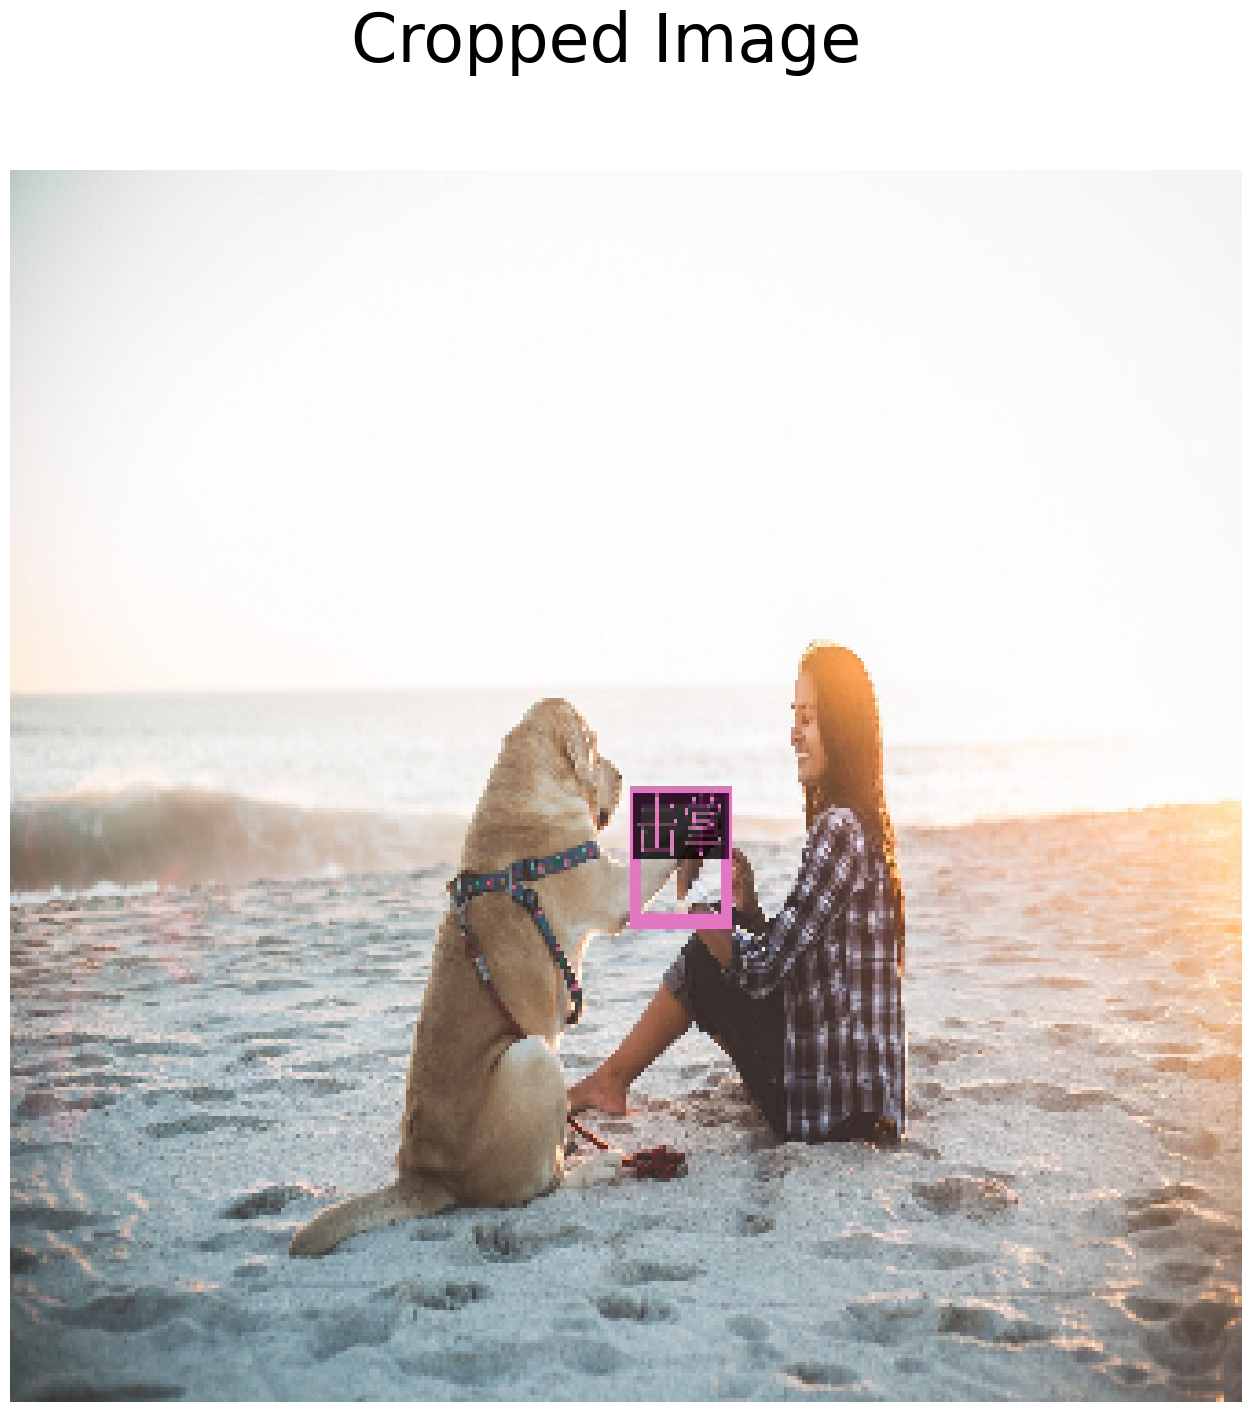

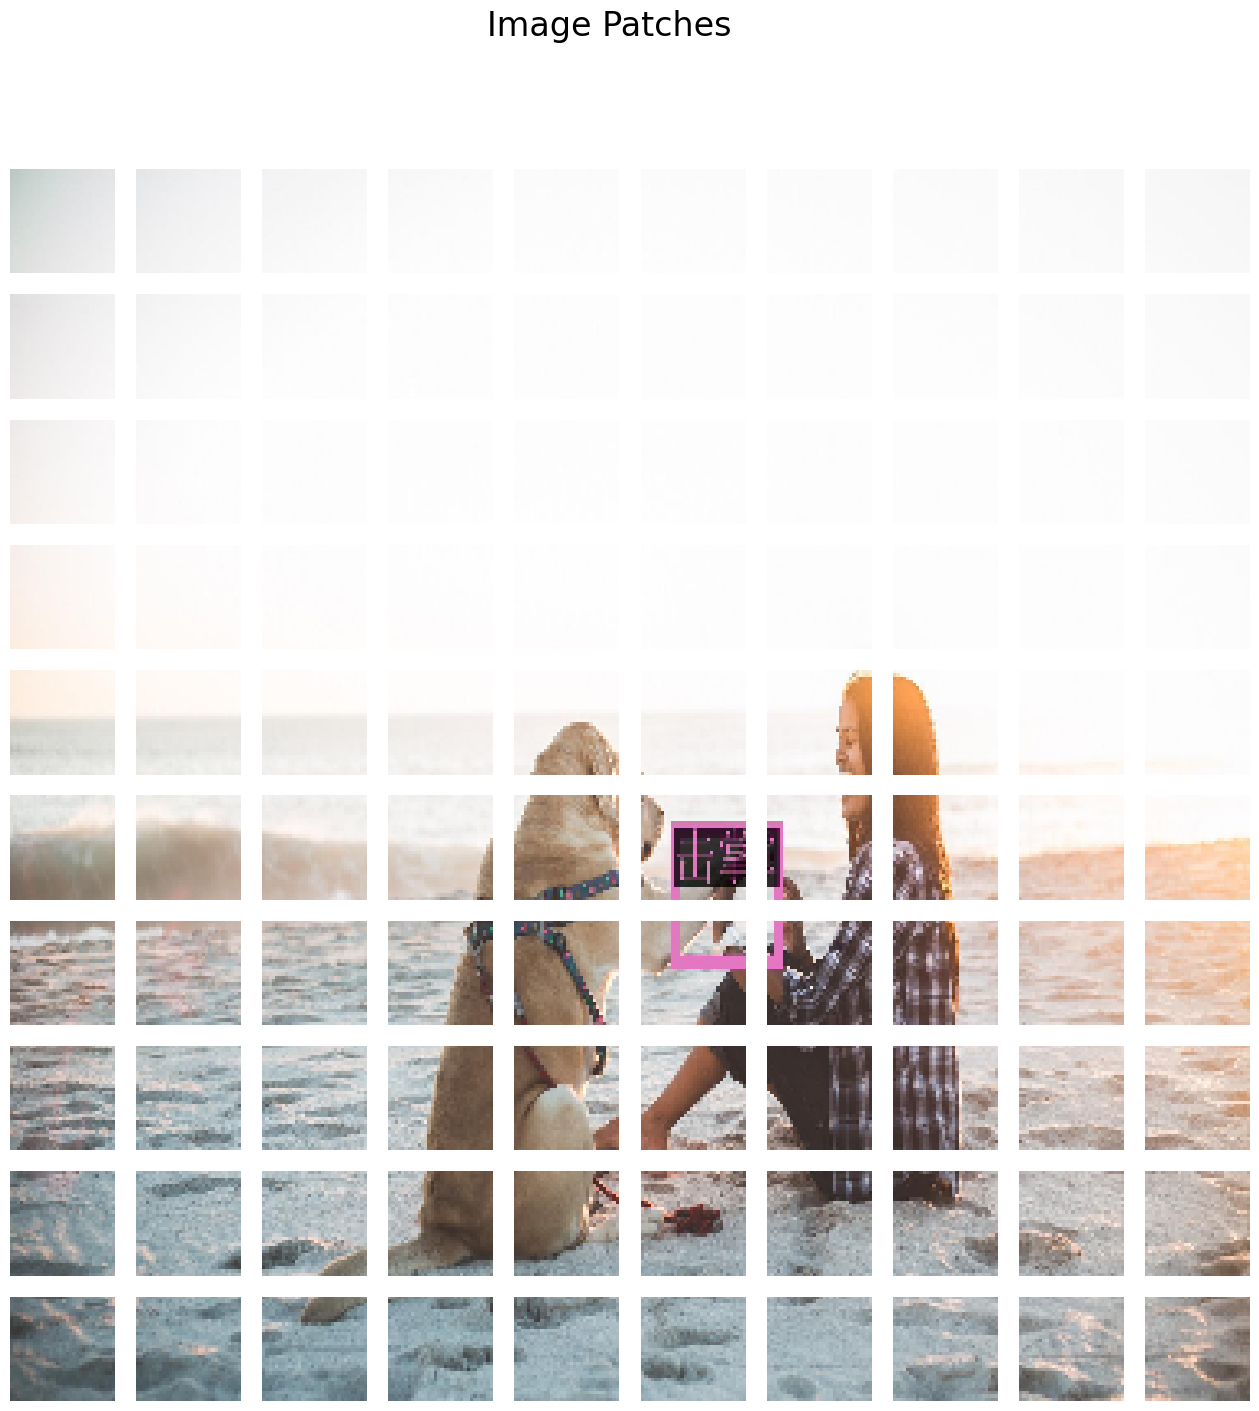

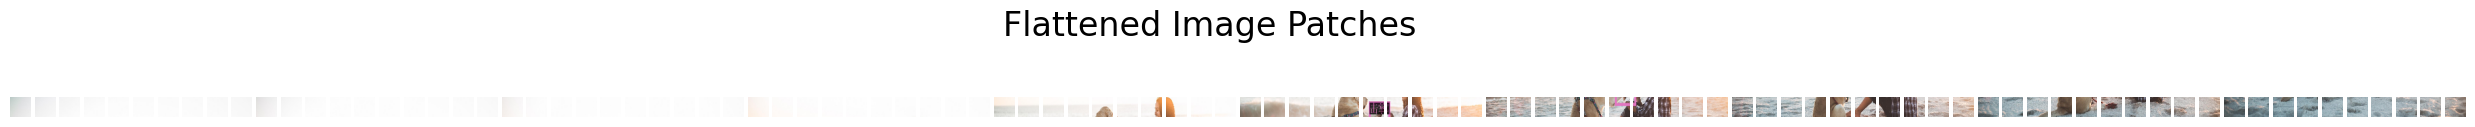

In [15]:
# Drawing
import numpy as np
import matplotlib.pyplot as plt

def render_image_and_patches(image, patches):
    plt.figure(figsize=(16, 16))
    plt.suptitle(f"Cropped Image", size=48)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.axis("off")
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(16, 16))
    plt.suptitle(f"Image Patches", size=24)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (32, 32, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis("off")

def render_flat(patches):
    plt.figure(figsize=(32, 2))
    plt.suptitle(f"Flattened Image Patches", size=24)
    n = int(np.sqrt(patches.shape[1]))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(1, 101, i+1)
        patch_img = tf.reshape(patch, (32, 32, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis("off")
        if(i == 100):
            break


render_image_and_patches(image_arr, patches)
render_flat(patches)